<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences,plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, Input, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 21.2MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### Tokenización

- Se tokenizan ahora las palabras.
- Al ser todas en inglés, se utiliza un solo tokenizador.
- Se limita el tamaño máximo del vocabulario con MAX_VOCAB_SIZE para evitar problemas de RAM.

In [8]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 5000

# Tokenizar las palabras de entrada con el Tokenizer de Keras
# Se usa un filtro propio para evitar el filtrado de los caracteres "<" y ">"
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
# Nota: Para reutilizar el mismo tokenizador, el fit se hace en ambos
# vectores (input y output) ya que puede haber términos que estén sólo
# en la entrada o en la salida.
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences) # Ver explicación de arriba
input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1 #Se agrega 1 para los caracteres desconocidos
print("Palabras en el vocabulario:", vocab_size)
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

# Tokenizar las palabras de salida
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
max_output_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de salida más larga:", max_output_len)

# Tokenizar las palabras de input/output que entran en el decoder
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

Palabras en el vocabulario: 2158
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 9


Para definir el tamaño máximo de entrada y salida se grafican histogramas:

(array([  45., 1420.,  496.,  658., 1030.,  933.,  633.,  733.,   82.,
           3.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

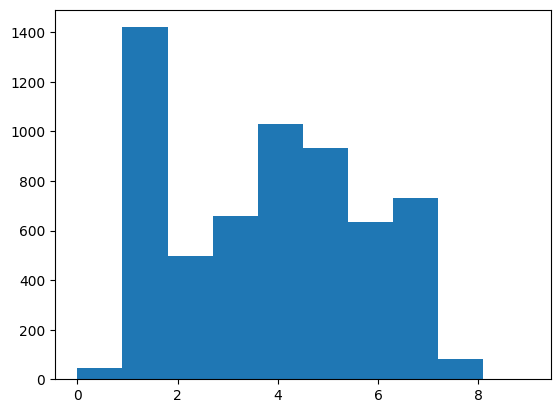

In [9]:
input_sentences_lengths = [len(x) for x in input_integer_seq]
plt.hist(input_sentences_lengths)

In [10]:
#Se decide probar con el tamaño máximo y ver qué produce el modelo
max_input_len = max(len(sen) for sen in input_integer_seq)
max_input_len

9

Se repite mismo análisis para las salidas

(array([  50., 1077.,  467.,  653., 1127., 1039.,  688.,  827.,   99.,
           6.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

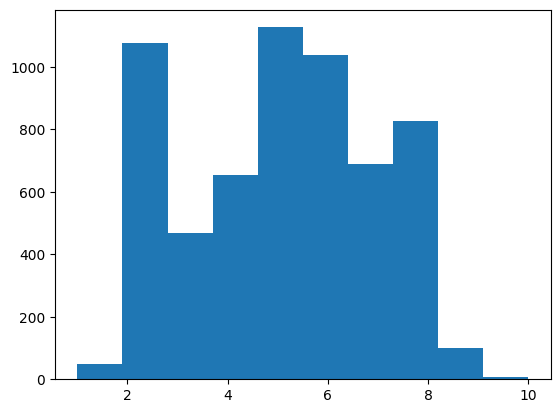

In [11]:
output_sentences_lengths = [len(x) for x in output_integer_seq]
plt.hist(output_sentences_lengths)

In [12]:
#Se decide probar con el tamaño máximo y ver qué produce el modelo
max_output_len = max(len(sen) for sen in output_integer_seq)
max_output_len

10

#### Preparación de los datos - padding

- Para el encoder se aplica el padding al comienzo.
- Para el decoder se aplica al final.

In [13]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_output_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=vocab_size)
decoder_targets.shape

(6033, 10, 2158)

### 3 - Preparar los embeddings

Se decide utilizar los embeddings de FastText para transformar los tokens de entrada en vectores

In [15]:
# Descarga de los embeddings
import os
import gdown

if os.access('cc.en.300.vec', os.F_OK) is False:
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
  !gunzip cc.en.300.vec.gz
# Check
!ls -lh cc.en.300.vec


if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

--2024-09-30 02:20:20--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   126MB/s    in 12s     

2024-09-30 02:20:32 (105 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

-rw-r--r-- 1 root root 4.3G Jan 18  2019 cc.en.300.vec


In [18]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [19]:
model_embeddings = FasttextEmbeddings()

In [23]:
# Crear la Embedding matrix de las secuencias
print('Preparando matriz de embeddings...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer
nb_words = min(MAX_VOCAB_SIZE+1, len(word2idx)+1) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # Las palabras que no se encuentren en Glove o FastTest se inicializan con ceros
        words_not_found.append(word)
        print(f"ADVERTENCIA!! La palabra {word} no se encontró en los embeddings pre-entrenados.")

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Preparando matriz de embeddings...
Number of null word embeddings: 1


In [ ]:
# Dimensión de los embeddings
embedding_matrix.shape

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

#### Definicion del modelo

In [24]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=[max_input_len])

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=[max_output_len])

decoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_output_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(nb_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 9, 300)         │        647,400 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 10, 300)        │        647,400 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │        219,648 │ embedding[0][0]        │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 10, 128),      │        219,648 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 2158)       │        278,382 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,012,478 (7.68 MB)

 Trainable params: 717,678 (2.74 MB)

 Non-trainable params: 1,294,800 (4.94 MB)

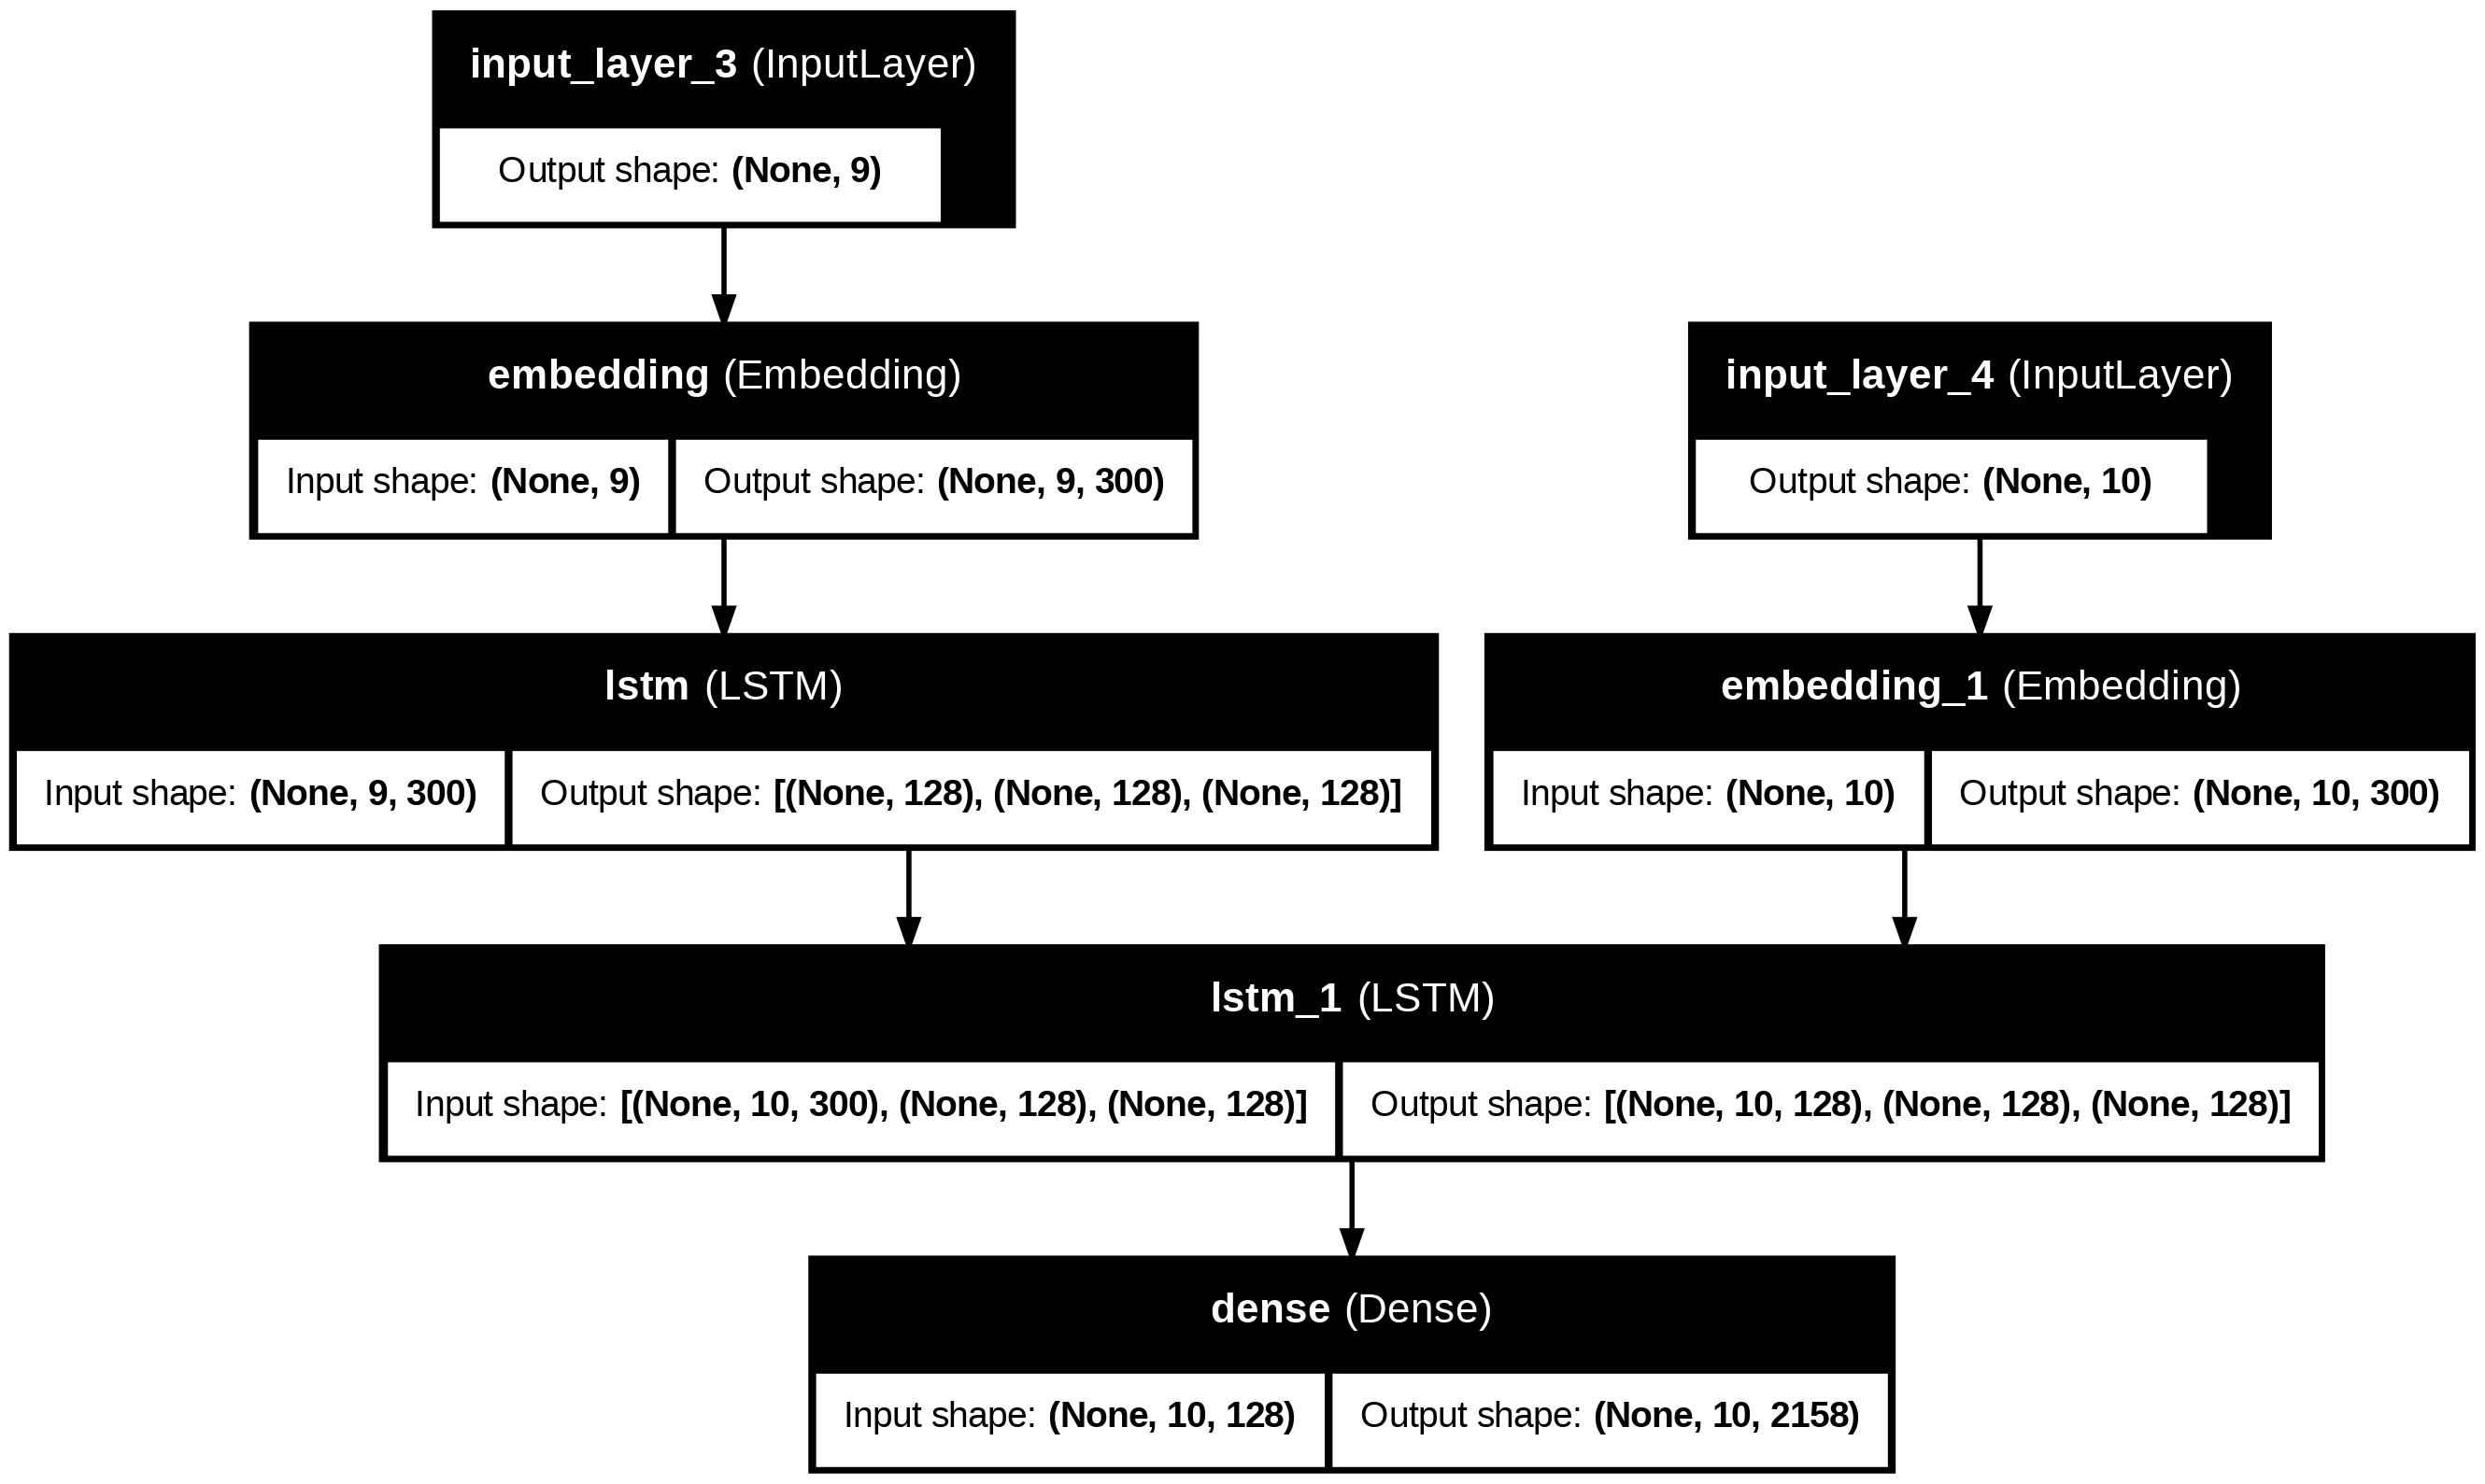

In [25]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

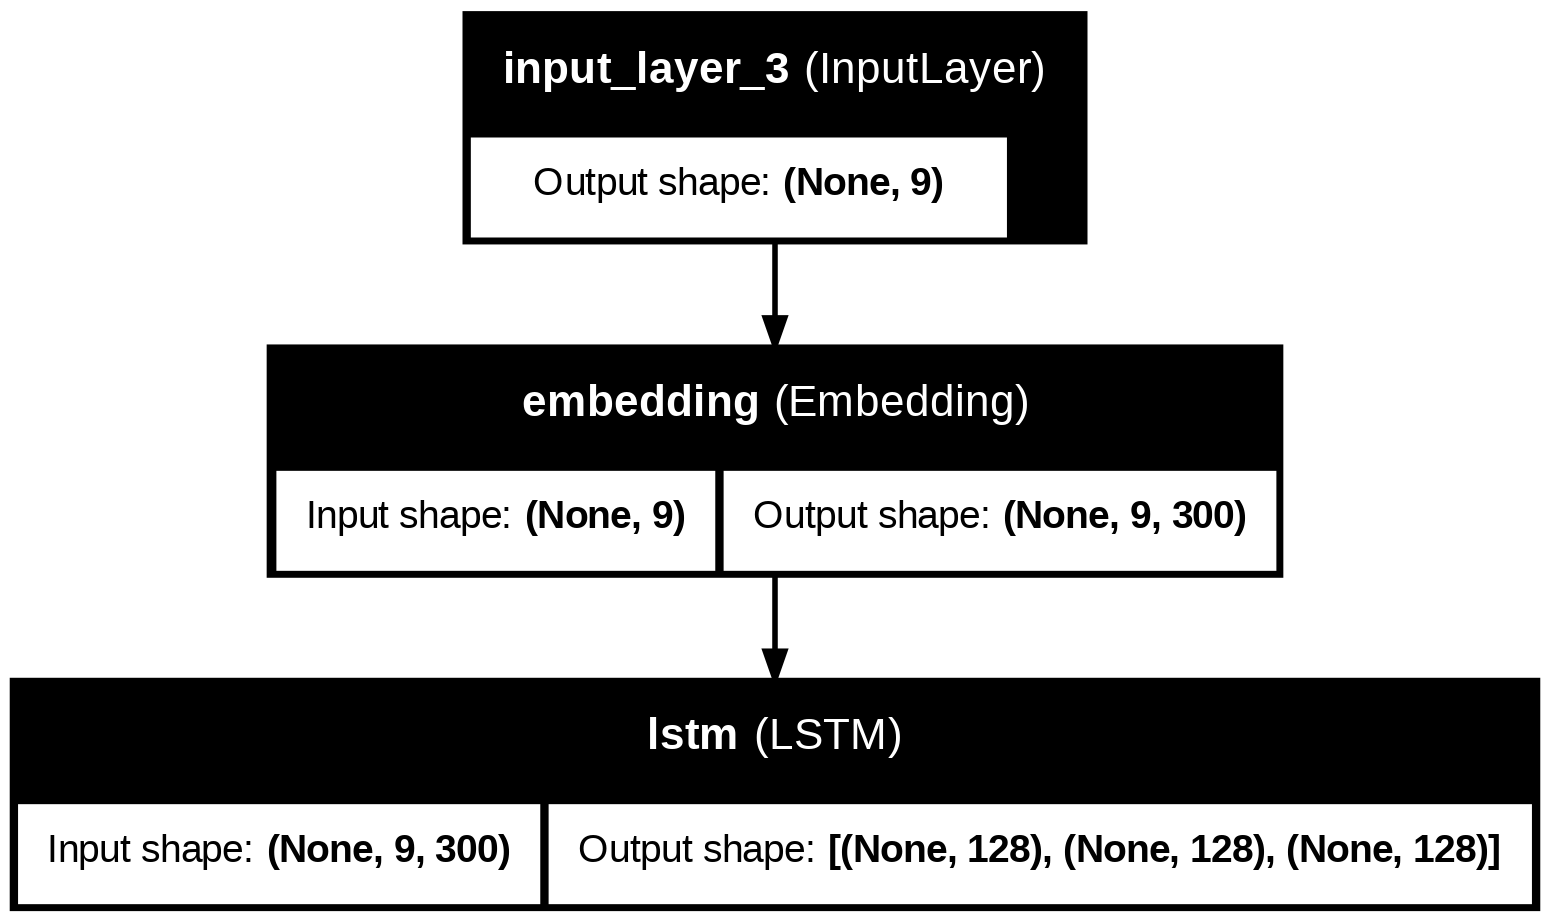

In [26]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

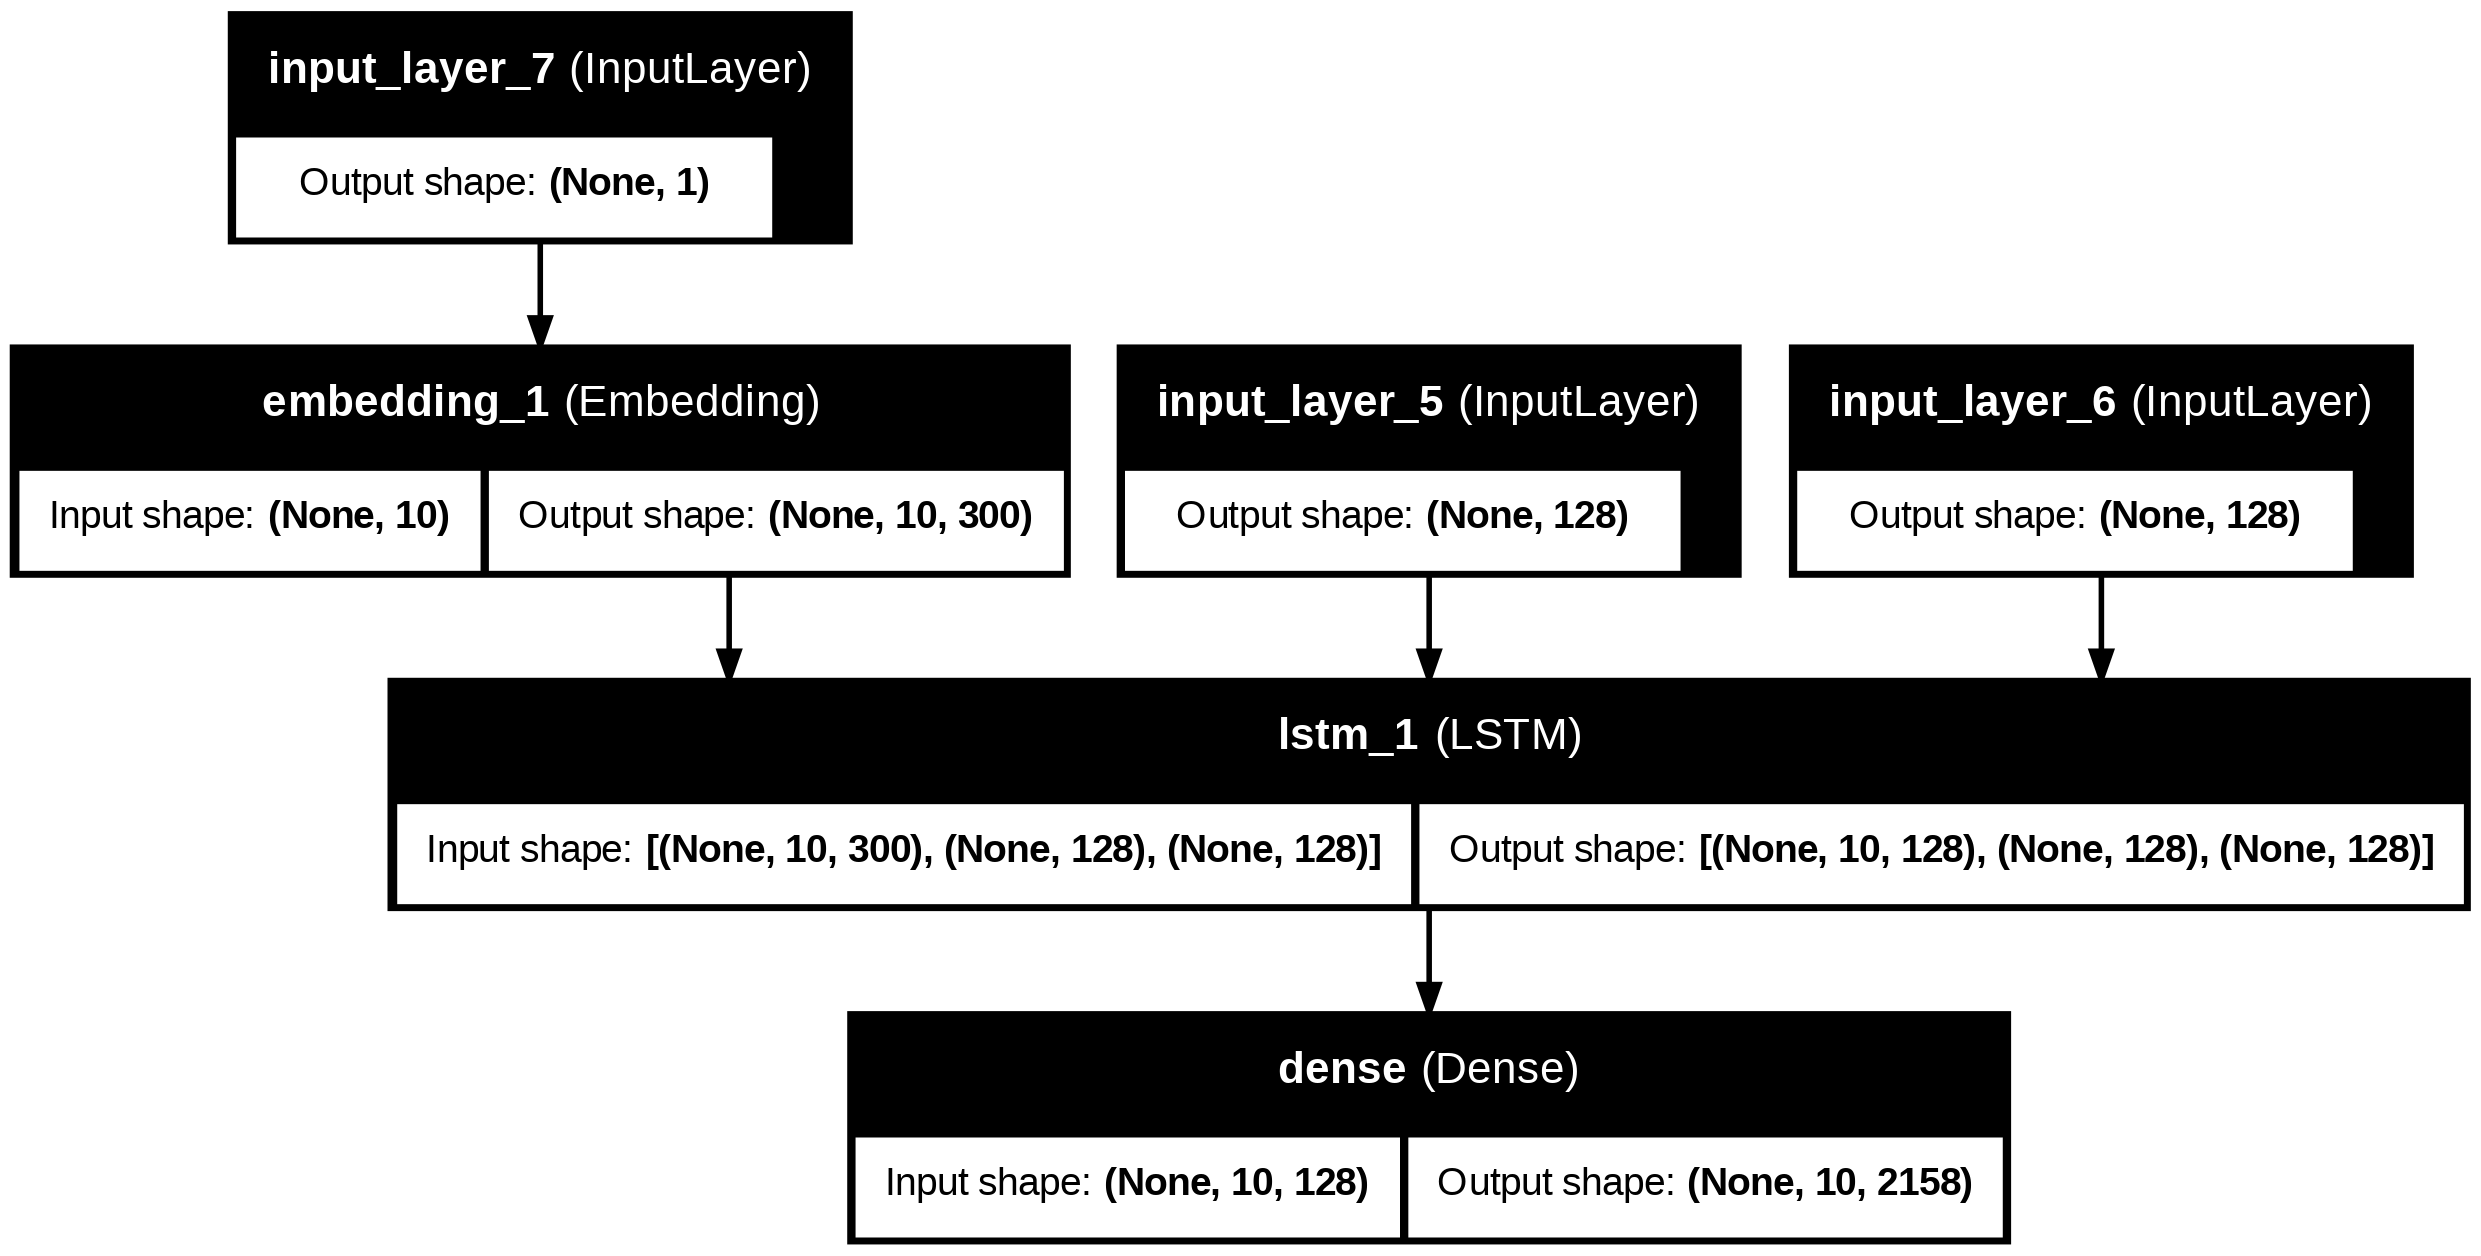

In [27]:
# Modelo solo decoder (para realizar inferencia)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

#### Entrenamiento

In [28]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15,
    validation_split=0.2)

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.4867 - loss: 4.2255 - val_accuracy: 0.6311 - val_loss: 2.2559
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6328 - loss: 2.0686 - val_accuracy: 0.6708 - val_loss: 2.0341
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6863 - loss: 1.8030 - val_accuracy: 0.6802 - val_loss: 1.9309
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7076 - loss: 1.6326 - val_accuracy: 0.6893 - val_loss: 1.8719
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7141 - loss: 1.5798 - val_accuracy: 0.6903 - val_loss: 1.8387
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7179 - loss: 1.5290 - val_accuracy: 0.6923 - val_loss: 1.8172
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7177 - loss: 1.4930 - val_accuracy: 0.6961 - val_loss: 1.8000
Epoch 8/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7281 - loss: 1.4288 - val_accur

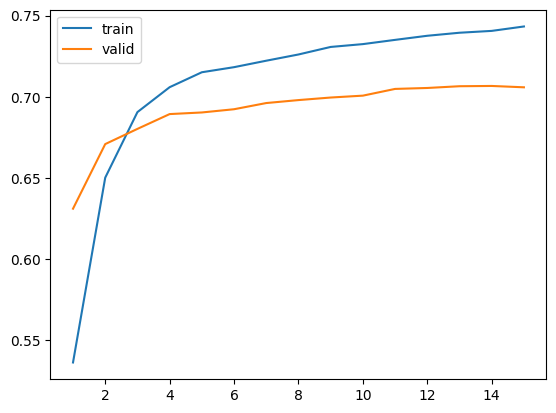

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [30]:
# Armar los conversores de índice a palabra:
idx2word = {v:k for k, v in word2idx.items()}

In [41]:
def generate_response(input_seq):
    """Función que dada una secuencia de entrada genera una respuesta."""
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx['<eos>']

    output_sentence = []
    for _ in range(max_output_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [51]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
response = generate_response(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
-
Input: what city are you from 
Response: i am a vegan


#### Preguntas de prueba

- a. Do you read?
- b. Do you have any pet?
- c. Where are you from?

In [56]:
def answer_question(input_text, quiet=False):
    integer_seq = tokenizer.texts_to_sequences([input_text])[0]
    encoder_sequence = pad_sequences([integer_seq], maxlen=max_input_len)
    response = generate_response(encoder_sequence)
    if not quiet:
      print("Representacion en vector de tokens de ids", integer_seq_test)
      print("Padding del vector:", encoder_sequence_test)
      print('Input:', input_text)
      print('Response:', response)
    return response

In [58]:
response = answer_question("Do you read?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Representacion en vector de tokens de ids [4, 3, 23]
Padding del vector: [[ 0  0  0  0  0  0  4  3 23]]
Input: Do you read?
Response: i like to go to the beach


In [59]:
response = answer_question("Do you have any pet?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Representacion en vector de tokens de ids [4, 3, 23]
Padding del vector: [[ 0  0  0  0  0  0  4  3 23]]
Input: Do you have any pet?
Response: i am a vegan


'i am a vegan'

In [60]:
response = answer_question("Where are you from?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Representacion en vector de tokens de ids [4, 3, 23]
Padding del vector: [[ 0  0  0  0  0  0  4  3 23]]
Input: Where are you from?
Response: i am a vegan
